In [1]:
# Import de librerias 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import lime
import lime.lime_tabular
import xgboost as xgb
import shap
import joblib
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from multiprocessing import Process
from interpret.blackbox import LimeTabular
from interpret import show
from interpret.blackbox import ShapKernel

c:\Users\david\Desktop\bug-prediction-explanation\env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# CONSTANTES
TEST_SIZE = 0.2
ENTRY_TO_EXPLAIN = 1
DATA_FILE = './datasets/dataset.xlsx'
SHEET_NAME = 'method'
# 0: sin modificaciones en los datos 
# 1: oversampling
# 2: undersampling
SAMPLED_DATA = 1
ENTRIES_TO_EXPLAIN = [5, 10, 14]

# Obtención de los datos

## Infomación

In [3]:
# Importado de los datos al dataframe 
df_original = pd.read_excel(DATA_FILE, sheet_name=SHEET_NAME)
df = df_original
df.head()

,Project,Hash,LongName,CC,CCL,CCO,CI,CLC,CLLC,LDC,...,Naming Rules,Optimization Rules,Security Code Guideline Rules,Strict Exception Rules,String and StringBuffer Rules,Type Resolution Rules,Unnecessary and Unused Code Rules,Vulnerability Rules,Number of Bugs,Buggy
0,hazelcast,0004065723dbb3f0219d5fde78068a98bfa22c1c,com.hazelcast.client.ClientTimeoutTest.testTim...,0,0,0,0,0,0,0,...,0,0,0,0,0,1,1,0,1,1
1,hazelcast,0004065723dbb3f0219d5fde78068a98bfa22c1c,com.hazelcast.client.connection.nio.ClientConn...,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,1
2,hazelcast,0004065723dbb3f0219d5fde78068a98bfa22c1c,com.hazelcast.client.connection.nio.ClientConn...,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
3,hazelcast,0004065723dbb3f0219d5fde78068a98bfa22c1c,com.hazelcast.client.connection.nio.ClientConn...,0,0,0,0,0,0,0,...,0,0,0,1,0,1,0,0,1,1
4,hazelcast,0004065723dbb3f0219d5fde78068a98bfa22c1c,com.hazelcast.client.spi.impl.ClusterListenerT...,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,1


## Limpieza

### Columnas no útiles

In [4]:
df = df.drop(['Project', 'Hash', 'LongName','Number of Bugs'], axis=1)
df

,CC,CCL,CCO,CI,CLC,CLLC,LDC,LLDC,HCPL,HDIF,...,Migration15 Rules,Naming Rules,Optimization Rules,Security Code Guideline Rules,Strict Exception Rules,String and StringBuffer Rules,Type Resolution Rules,Unnecessary and Unused Code Rules,Vulnerability Rules,Buggy
0,0,0,0,0,0,0,0,0,148093,163636,...,0,0,0,0,0,0,1,1,0,1
1,0,0,0,0,0,0,0,0,212183,248,...,0,0,0,0,1,0,0,0,0,1
2,0,0,0,0,0,0,0,0,299316,36,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,349426,4386,...,0,0,0,0,1,0,1,0,0,1
4,0,0,0,0,0,0,0,0,513541,536364,...,0,0,0,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108101,0,0,0,0,0,0,0,0,118039,33,...,0,0,0,0,0,0,0,0,0,0
108102,0,0,0,0,0,0,0,0,213303,308571,...,0,0,0,0,1,0,0,0,0,0
108103,0,0,0,0,0,0,0,0,247176,303947,...,0,0,0,0,1,0,0,0,0,0
108104,0,0,0,0,0,0,0,0,193219,368,...,0,0,0,0,1,0,0,0,0,0


### Columnas con único valor

In [5]:
# Eliminación de columnas con un único valor 
df = df[[i for i in df if len(set(df[i]))>1]]
df

,CC,CCL,CCO,CI,CLC,CLLC,LDC,LLDC,HCPL,HDIF,...,Migration Rules,Naming Rules,Optimization Rules,Security Code Guideline Rules,Strict Exception Rules,String and StringBuffer Rules,Type Resolution Rules,Unnecessary and Unused Code Rules,Vulnerability Rules,Buggy
0,0,0,0,0,0,0,0,0,148093,163636,...,0,0,0,0,0,0,1,1,0,1
1,0,0,0,0,0,0,0,0,212183,248,...,0,0,0,0,1,0,0,0,0,1
2,0,0,0,0,0,0,0,0,299316,36,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,349426,4386,...,0,0,0,0,1,0,1,0,0,1
4,0,0,0,0,0,0,0,0,513541,536364,...,0,0,0,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108101,0,0,0,0,0,0,0,0,118039,33,...,0,0,0,0,0,0,0,0,0,0
108102,0,0,0,0,0,0,0,0,213303,308571,...,0,0,0,0,1,0,0,0,0,0
108103,0,0,0,0,0,0,0,0,247176,303947,...,0,0,0,0,1,0,0,0,0,0
108104,0,0,0,0,0,0,0,0,193219,368,...,0,0,0,0,1,0,0,0,0,0


### Filas duplicadas

In [6]:
# No interesa la eliminación de filas duplicadas ya que puede ser que si que se produzca un fallo siempre que se tengan los mismos datos 

# Comprobación de filas duplicadas 
# print('Filas duplicadas: ', df.duplicated().sum())
# Eliminación de las filas duplicadas
# df = df.drop_duplicates()
# Comprobación de la eliminación correcta de las filas duplicadas eliminadas
print( 'Filas duplicadas: ', df.duplicated().sum())

Filas duplicadas:  27483


### Valores NULL

In [7]:
print('Valores Null: ', df.isnull().sum().sum())

Valores Null:  0


### Valores atípicos

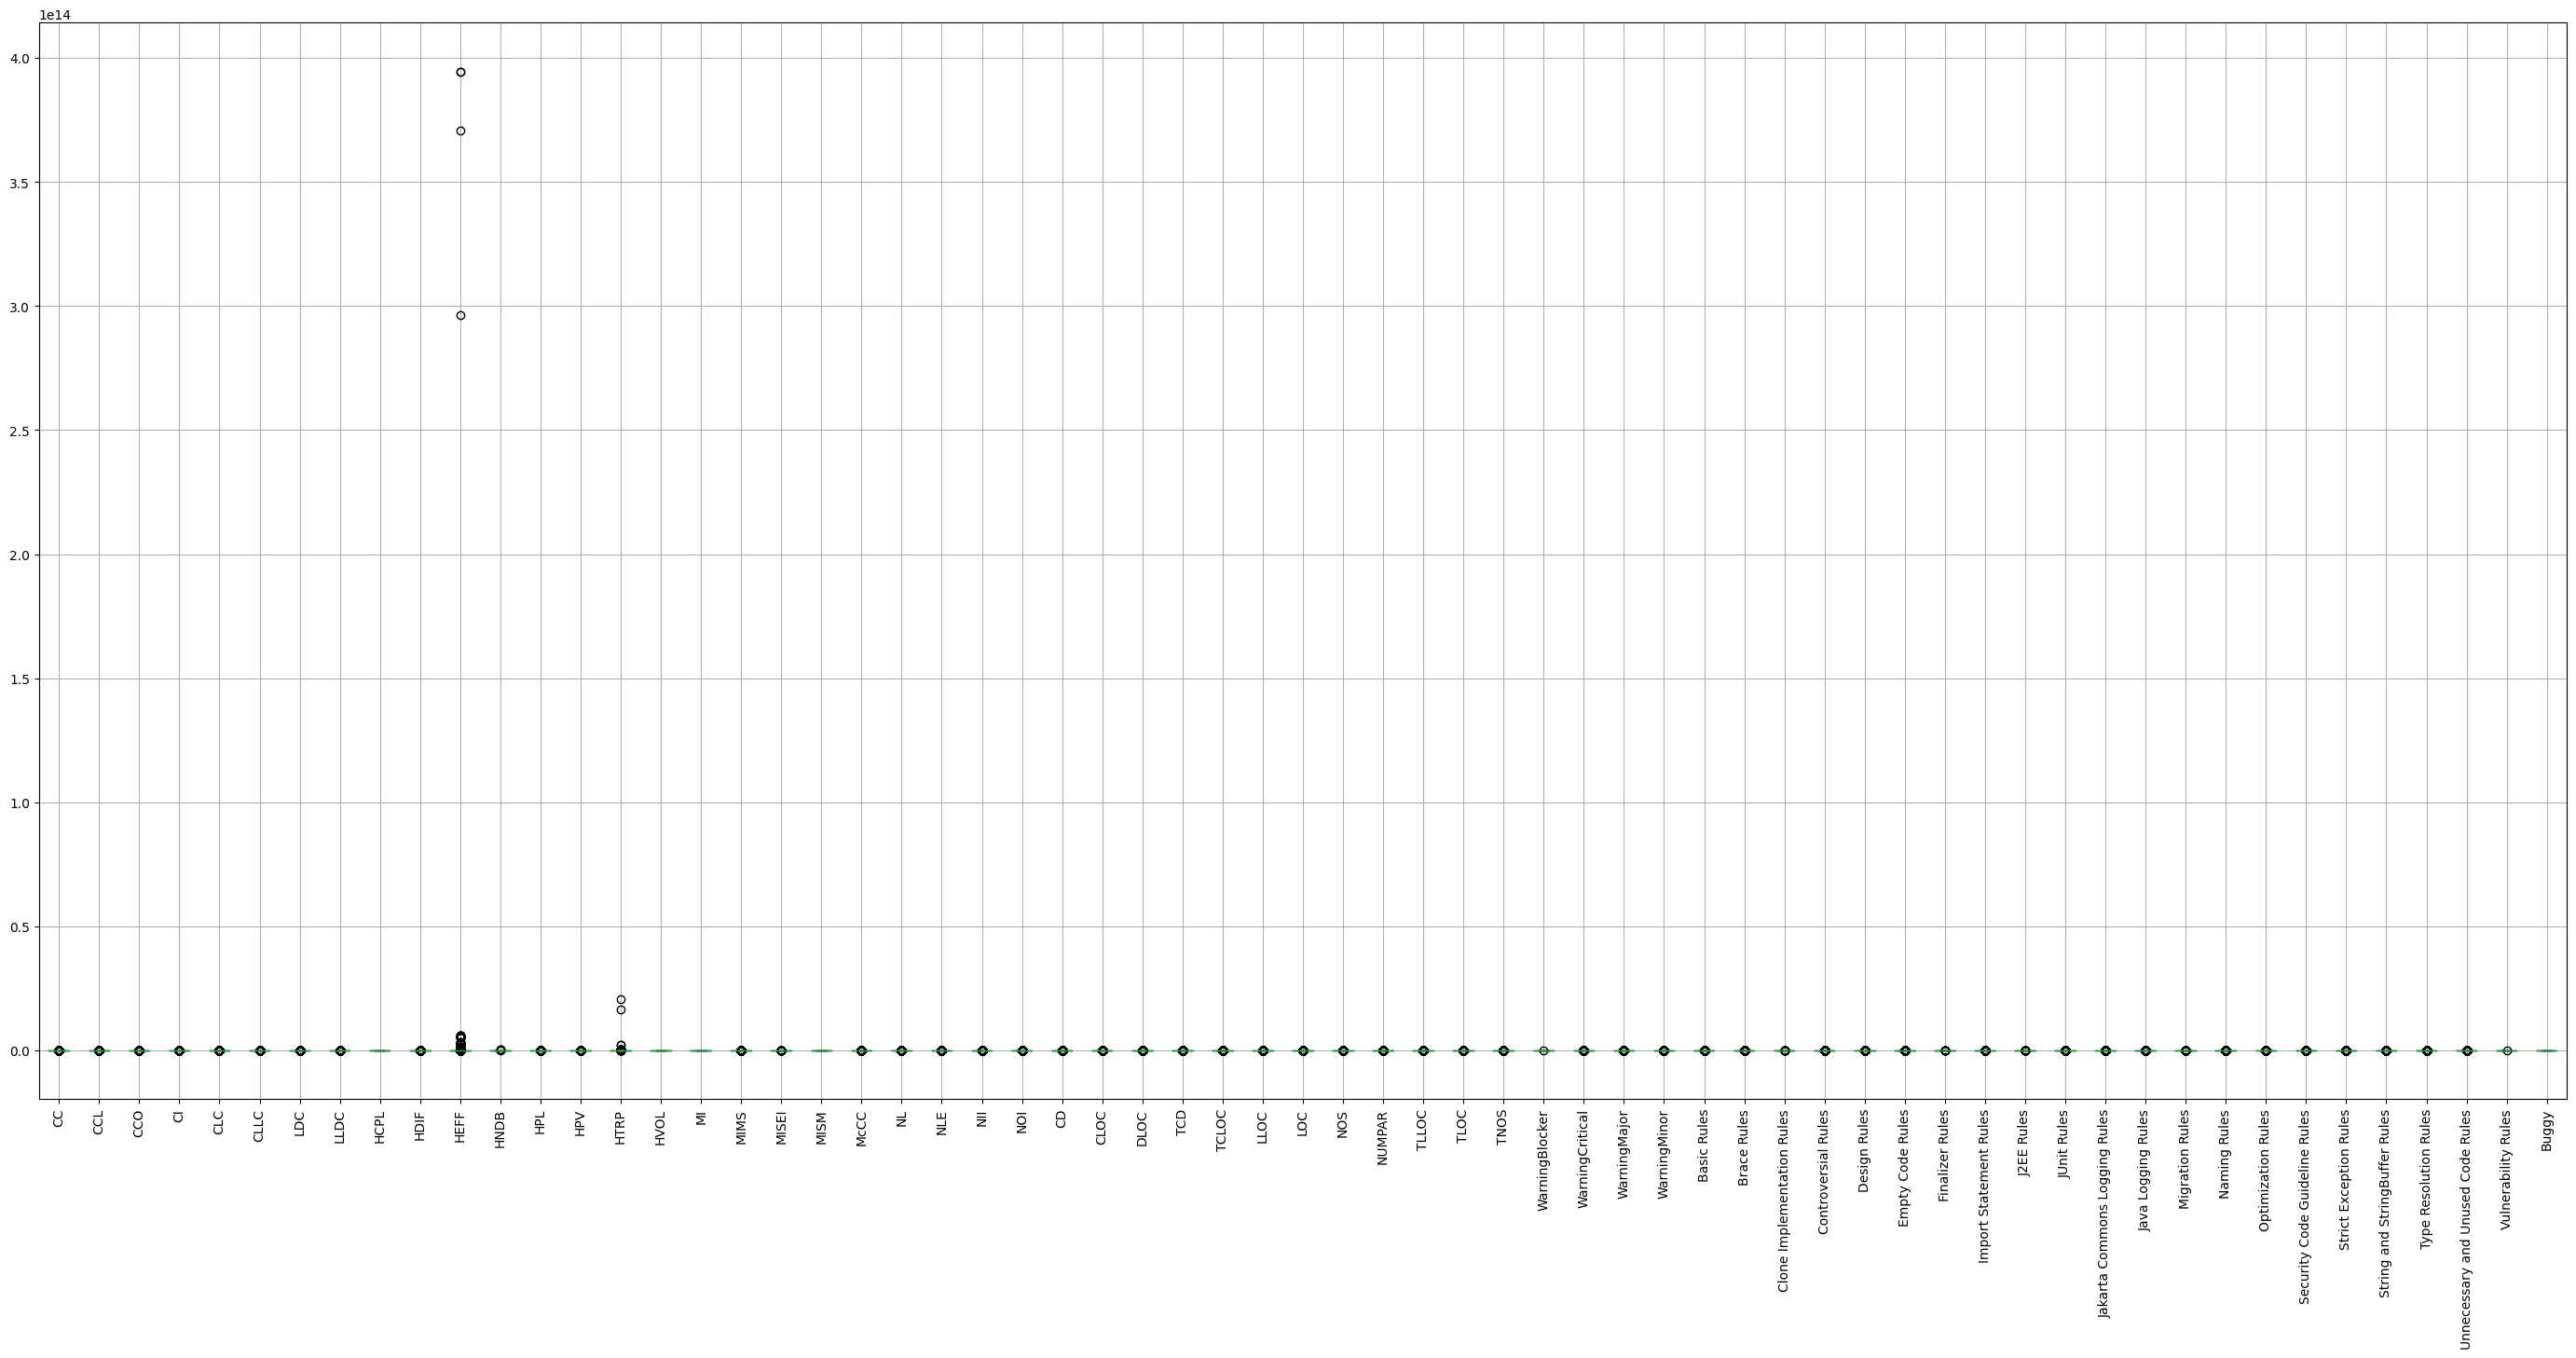

In [8]:
# Muestra de los valores atípicos para cada una de las features
plt.figure(figsize=(35,15))
df.boxplot()
plt.xticks(rotation=90)
plt.show()

## Separación de features y salida

In [9]:
# Separación de los valores de entrada para el entrenamiento del modelo y los valores de salida
x = df.drop('Buggy', axis=1)  # valores de entrada
y = df['Buggy']  # valores de salida

In [10]:
x

,CC,CCL,CCO,CI,CLC,CLLC,LDC,LLDC,HCPL,HDIF,...,Java Logging Rules,Migration Rules,Naming Rules,Optimization Rules,Security Code Guideline Rules,Strict Exception Rules,String and StringBuffer Rules,Type Resolution Rules,Unnecessary and Unused Code Rules,Vulnerability Rules
0,0,0,0,0,0,0,0,0,148093,163636,...,0,0,0,0,0,0,0,1,1,0
1,0,0,0,0,0,0,0,0,212183,248,...,0,0,0,0,0,1,0,0,0,0
2,0,0,0,0,0,0,0,0,299316,36,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,349426,4386,...,0,0,0,0,0,1,0,1,0,0
4,0,0,0,0,0,0,0,0,513541,536364,...,2,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108101,0,0,0,0,0,0,0,0,118039,33,...,0,0,0,0,0,0,0,0,0,0
108102,0,0,0,0,0,0,0,0,213303,308571,...,0,0,0,0,0,1,0,0,0,0
108103,0,0,0,0,0,0,0,0,247176,303947,...,0,0,0,0,0,1,0,0,0,0
108104,0,0,0,0,0,0,0,0,193219,368,...,0,0,0,0,0,1,0,0,0,0


In [11]:
y

0         1
1         1
2         1
3         1
4         1
         ..
108101    0
108102    0
108103    0
108104    0
108105    1
Name: Buggy, Length: 108106, dtype: int64

# Conjuntos de entrenamiento y test

In [12]:
# División del dataframe en los conjuntos de test y entrenamiento
X_train , X_test, y_train, y_test = train_test_split(x, y, test_size=TEST_SIZE, random_state=42)

### Normalización del Dataframe
Esta normalización ha de hacerse una vez construidos los conjuntos de test y entrenamiento, para que los datos de test no afecten a la normalización de los datos de entrenamiento. 

In [13]:
# Normalización de los conjuntos 

# normalized_df = (df-df.mean())/df.std()
# df_normalized = (df-df.min())/(df.max()-df.min())

scaler = MinMaxScaler(feature_range = (0, 10000))
X_train_normalized = pd.DataFrame(
    scaler.fit_transform(X_train),
    columns = X_train.columns
)

# y_train_normalized = scaler.fit_transform(y_train.values.reshape(0,100))
y_train_normalized = y_train

X_test_normalized = pd.DataFrame(
    scaler.transform(X_test),
    columns = X_test.columns
)

# y_test_normalized = scaler.fit_transform(y_test.values.reshape(-1,1))
y_test_normalized = y_test

In [14]:
X_train_normalized.describe()

,CC,CCL,CCO,CI,CLC,CLLC,LDC,LLDC,HCPL,HDIF,...,Java Logging Rules,Migration Rules,Naming Rules,Optimization Rules,Security Code Guideline Rules,Strict Exception Rules,String and StringBuffer Rules,Type Resolution Rules,Unnecessary and Unused Code Rules,Vulnerability Rules
count,86484.000000,86484.000000,86484.000000,86484.000000,86484.000000,86484.000000,86484.000000,86484.000000,86484.000000,86484.000000,...,86484.000000,86484.000000,86484.000000,86484.000000,86484.000000,86484.000000,86484.000000,86484.000000,86484.000000,86484.000000
mean,483.016192,14.234102,1.730034,8.845731,408.611744,408.177763,12.529870,12.920279,3374.948055,1681.709570,...,9.861085,1.638068,60.430253,8.564205,13.489971,87.728861,14.205202,160.064289,7.864190,0.115628
std,1722.611888,250.273496,56.940057,239.308300,1542.716590,1545.468077,237.767353,250.424352,2556.530480,2439.951451,...,95.617719,78.307807,301.365541,113.046596,227.990885,331.321377,125.283457,409.229885,187.079923,34.004165
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1386.212802,0.440204,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2653.177190,45.130896,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4874.869197,2671.069205,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,...,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000


## Desbalanceo de datos

In [15]:
# Comprobación de la cantidad de datos para cada una de las salidas
print(Counter(y_train))

Counter({0: 59837, 1: 26647})


### Random Oversampling
De manera aleatoria duplica ejemplos en la clase minoritaria.

Al igual que la normalización, esta técnica de muestreo es necesario aplicarla sobre os conjuntos divididos de testeo y entrenamiento ya que si se realiza antes, los datos de entrenamiento estarán contaminados por los de test, existiendo la posibilidad de que al replicar las entradas se esojan estas entradas tanto para el conjunto de testeo como para el de entrenamiento

In [16]:
# Usando "minority" como "sampling_strategy" se consigue que si por ejemplo la clase mayoritaria tiene 1000 entradas y la minoritaria 100, la clase minoritaria replicará aleatoriamente las entradas hasta llegar a las 1000 de la clase mayoritaria
oversample = RandomOverSampler(sampling_strategy='minority')
X_train_normalized_oversampled, y_train_normalized_oversampled = oversample.fit_resample(X_train_normalized, y_train_normalized)
print(Counter(y_train_normalized_oversampled))

Counter({0: 59837, 1: 59837})


### Undersampling

In [17]:
# Usando "minority" como "sampling_strategy" se consigue que si por ejemplo la clase mayoritaria tiene 1000 entradas y la minoritaria 100, la clase minoritaria replicará aleatoriamente las entradas hasta llegar a las 1000 de la clase mayoritaria
undersample = RandomUnderSampler(sampling_strategy='majority')
x_under, y_under = undersample.fit_resample(x, y)
print(Counter(y_under))

Counter({0: 33324, 1: 33324})


# Random Forest

## Ajuste de hiperparámetros
Antes de la construcción del modelo de random forest comprobamos los mejores hiperparámetros para el modelo.

Grid Search es una técnica de validación cruzada que ejecuta la combinación entre los parámetros introducidos como entrada para seleccionar la mejor combinación de estos.

HIPERPARÁMETROS: 
  - n_estimators: representa el número de estimadores (árboles de decisión en este caso) que se deben utilizar en el modelo
  - max_depth: indica la profundidad máxima de los árboles del modelo 
  - min_samples_split: determina el número de muestras requeridas para diidir un nodo en un árbol. Influye en la resistencia frente al ruido de los datos. 
  - max_features: controla el número máximo de características que se consideran al buscar la mejor deisión en un nodo del árbol 
  
PARÁMETROS: 
  - cv: indica la estrategia de validación cruzada seguida 
  - neg_root_mean_squared_error: error cuadrático medio expresado en su forma negativa 
  - r2: indica cuanto se explica la variabilidad de los datos a través del modelo de regresión. Sus valores oscilan entre 0 y 1, siendo mejores cuanto más próximos a 1 se encuentren   

In [18]:
rf = RandomForestClassifier(random_state = 42)

search_space = {
    "max_depth": [100],
    "max_features": [4], 
    "min_samples_leaf" : [1],
    "min_samples_split": [1],
    "n_estimators": [600]
}

GS = GridSearchCV(estimator = rf,
                 param_grid = search_space,
                 scoring = ["r2", "neg_root_mean_squared_error"],
                 refit = "r2",
                 cv = 5,
                 verbose = 4, 
                 n_jobs=-1)

# GS.fit(X_train_normalized_oversampled, y_train_normalized_oversampled)

# print(GS.best_params_)

'''
ANTIGUOS
MAX_DEPTH = 75 > 70 > 80 > 85 > 300, 100 > 50 > 40 > 35 > 25
MAX_FEATURES = 5 > 1 > 10 > 20 > 25 > 30 > 40 > 62
MIN_SAMPLES_LEAF = 1 > 3, 5
MIN_SAMPLES_SPLIT = 2 > 3 > 1, 5
N_ESTIMATORS = 1000 > 1150 > 700 > 600 > 500 > 300
'''
'''
NUEVOS
MAX_DEPTH = 100 > 200 > 300 > 25, 75
MAX_FEATURES = 4 > 3 > 5 > 6 > 1 > 20 
MIN_SAMPLES_LEAF = 1 > 3 
MIN_SAMPLES_SPLIT = 1 > 2 
N_ESTIMATORS = 600 > 700 > 500 > 1000
'''

'\nNUEVOS\nMAX_DEPTH = 100 > 200 > 300 > 25, 75\nMAX_FEATURES = 4 > 3 > 5 > 6 > 1 > 20 \nMIN_SAMPLES_LEAF = 1 > 3 \nMIN_SAMPLES_SPLIT = 1 > 2 \nN_ESTIMATORS = 600 > 700 > 500 > 1000\n'

In [19]:
MAX_DEPTH = 100
MAX_FEATURES = 4
MIN_SAMPLES_LEAF = 1
MIN_SAMPLES_SPLIT = 1
N_ESTIMATORS = 600
# Creación del modelo de random forest con los hiperparámetros seleccionados del paso anterior

# Modelo rápido para pruebas
# rf = RandomForestClassifier(max_depth= 35, max_features= 20, min_samples_split= 50, n_estimators= 300, n_jobs=-1)

# Modelo completo
rf = RandomForestClassifier(max_depth = MAX_DEPTH, max_features = MAX_FEATURES, min_samples_split = MIN_SAMPLES_SPLIT, n_estimators = N_ESTIMATORS, min_samples_leaf = MIN_SAMPLES_LEAF, n_jobs = -1)

## Elección de modelo

In [20]:
# # Original 
# if (SAMPLED_DATA == 0):
# 	rf.fit(X_train_original, y_train_original)
# 	X_train = X_train_original
# 	y_train = y_train_original
# 	X_test = X_test_original
# 	y_test = y_test_original
# # Oversampling
# elif (SAMPLED_DATA == 1):
# 	rf.fit(X_train_oversampled, y_train_oversampled)
# 	X_train = X_train_oversampled
# 	y_train = y_train_oversampled
# 	X_test = X_test_oversampled
# 	y_test = y_test_oversampled
# # Undersampling
# elif (SAMPLED_DATA == 2):
# 	# rf.fit(X_train_undersampled, y_train_undersampled)
# 	X_train = X_train_undersampled
# 	y_train = y_train_undersampled
# 	X_test = X_test_undersampled
# 	y_test = y_test_undersampled

X_train = X_train_normalized_oversampled
y_train = y_train_normalized_oversampled
X_test = X_test_normalized
y_test = y_test_normalized
rf.fit(X_train, y_train)

## Evaluación del modelo

http://iamirmasoud.com/2022/06/19/understanding-micro-macro-and-weighted-averages-for-scikit-learn-metrics-in-multi-class-classification-with-example/

### Métricas de evaluación
#### Confusion Matrix
Una confusion matrix es una forma de expresar cuántas predicciones de un clasificador fueron correctas y, cuando son incorrectas, dónde el clasificador se confundió (de ahí el nombre). En las matrices de confusión a continuación, las filas representan las etiquetas verdaderas y las columnas representan las etiquetas predichas. Los valores en la diagonal representan el número (o porcentaje, en una matriz de confusión normalizada) de veces en que la etiqueta predicha coincide con la etiqueta verdadera. Los valores en las otras celdas representan instancias donde el clasificador etiquetó incorrectamente una observación; la columna nos dice qué predijo el clasificador y la fila nos dice cuál era la etiqueta correcta. Esta es una forma conveniente de identificar áreas donde el modelo puede necesitar un poco de entrenamiento adicional.
#### Precision
Precision es el número de miembros de una clase que el modelo ha identificado correctamente dividido entre todas las veces que el modelo ha predicho esa clase.
#### Recall
La sensibilidad o recall es el número de miembros de una clase que el clasificador identificó correctamente dividido por el número total de miembros en esa clase.
#### F1 score
El F1 score es un poco menos intuitivo porque combina precisión y recall en una sola métrica. Si tanto la precisión como el recall son altos, F1 también será alto. Si ambos son bajos, F1 será bajo. Si uno es alto y el otro bajo, F1 será bajo. F1 es una forma rápida de saber si el clasificador es realmente bueno para identificar miembros de una clase, o si está encontrando atajos (por ejemplo, simplemente identificando todo como miembro de una clase grande).

In [21]:
def evaluacion_modelo(model, x_test, y_test, prediccion): 
	# View the classification report for test data and predictions
	print(classification_report(y_test, prediccion))

	conf_matrix = confusion_matrix(y_test, prediccion)
	conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

	# Confusion matrix usando un heat map
	sns.set(font_scale=1)
	sns.heatmap(conf_matrix, annot=True, cmap=plt.cm.Greens)

	# Labels 
	class_names = ['Not Buggy', 'Buggy']
	tick_marks = np.arange(len(class_names))
	tick_marks2 = tick_marks + 0.5
	plt.xticks(tick_marks, class_names, rotation=30)
	plt.yticks(tick_marks2, class_names, rotation=0)
	plt.xlabel('Predicciones')
	plt.ylabel('Valores reales')
	plt.title('Matriz de confusion')
	plt.show()

	# calculate ROC curve
	fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(x_test)[:, 1])
	roc_auc = auc(fpr, tpr)

	# plot ROC curve
	plt.plot(fpr, tpr, label="ROC curve (AUC = {:.2f})".format(roc_auc))
	plt.plot([0, 1], [0, 1], linestyle="--", label="Random guess")
	plt.xlabel("False Positive Rate")
	plt.ylabel("True Positive Rate")
	plt.title("Receiver Operating Characteristic (ROC) Curve")
	plt.legend()

              precision    recall  f1-score   support

           0       0.78      0.88      0.82     14945
           1       0.61      0.44      0.51      6677

    accuracy                           0.74     21622
   macro avg       0.70      0.66      0.67     21622
weighted avg       0.73      0.74      0.73     21622



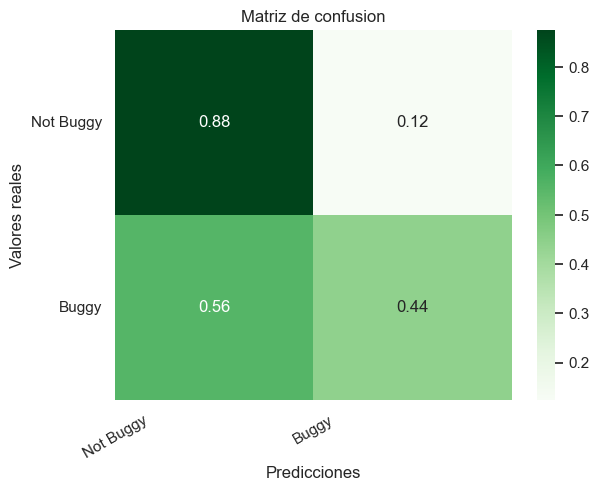

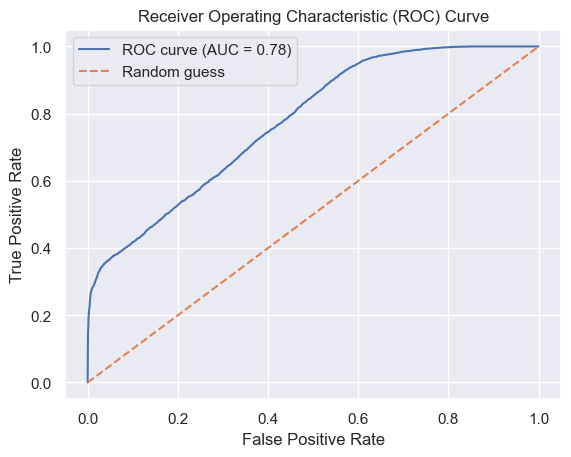

In [73]:
# rf = RandomForestClassifier(max_depth = 18, max_features = 10, min_samples_leaf = 10, min_samples_split = 10, n_estimators = 50, n_jobs = -1)
# rf = RandomForestClassifier(max_depth = 18, max_features = 50, min_samples_leaf = 10, min_samples_split = 10, n_estimators = 50, n_jobs = -1)
# rf = RandomForestClassifier(max_depth = 15, max_features = 10, min_samples_leaf = 3, min_samples_split = 15, n_estimators = 50, n_jobs = -1)
rf = RandomForestClassifier(max_depth = 100, max_features = 4, min_samples_leaf = 1, min_samples_split = 1, n_estimators = 600, n_jobs = -1)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
evaluacion_modelo(rf, X_test, y_test, y_pred)

              precision    recall  f1-score   support

           0       0.78      0.88      0.82     14945
           1       0.62      0.45      0.52      6677

    accuracy                           0.74     21622
   macro avg       0.70      0.66      0.67     21622
weighted avg       0.73      0.74      0.73     21622



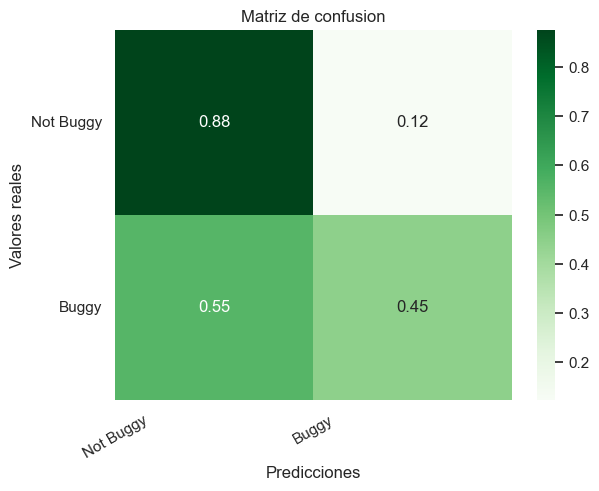

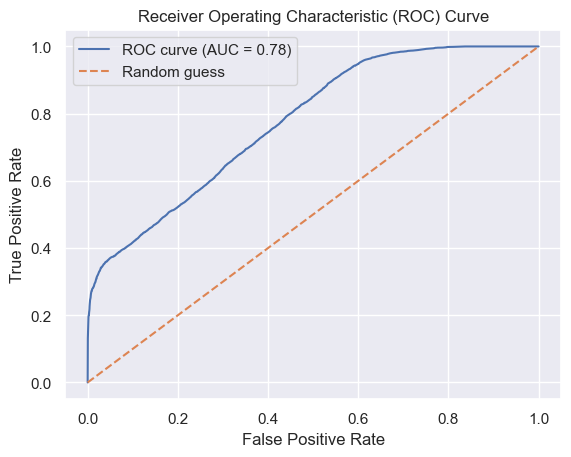

In [22]:
y_pred = rf.predict(X_test)
evaluacion_modelo(rf, X_test, y_test, y_pred)

## Importancia de las features

<Axes: >

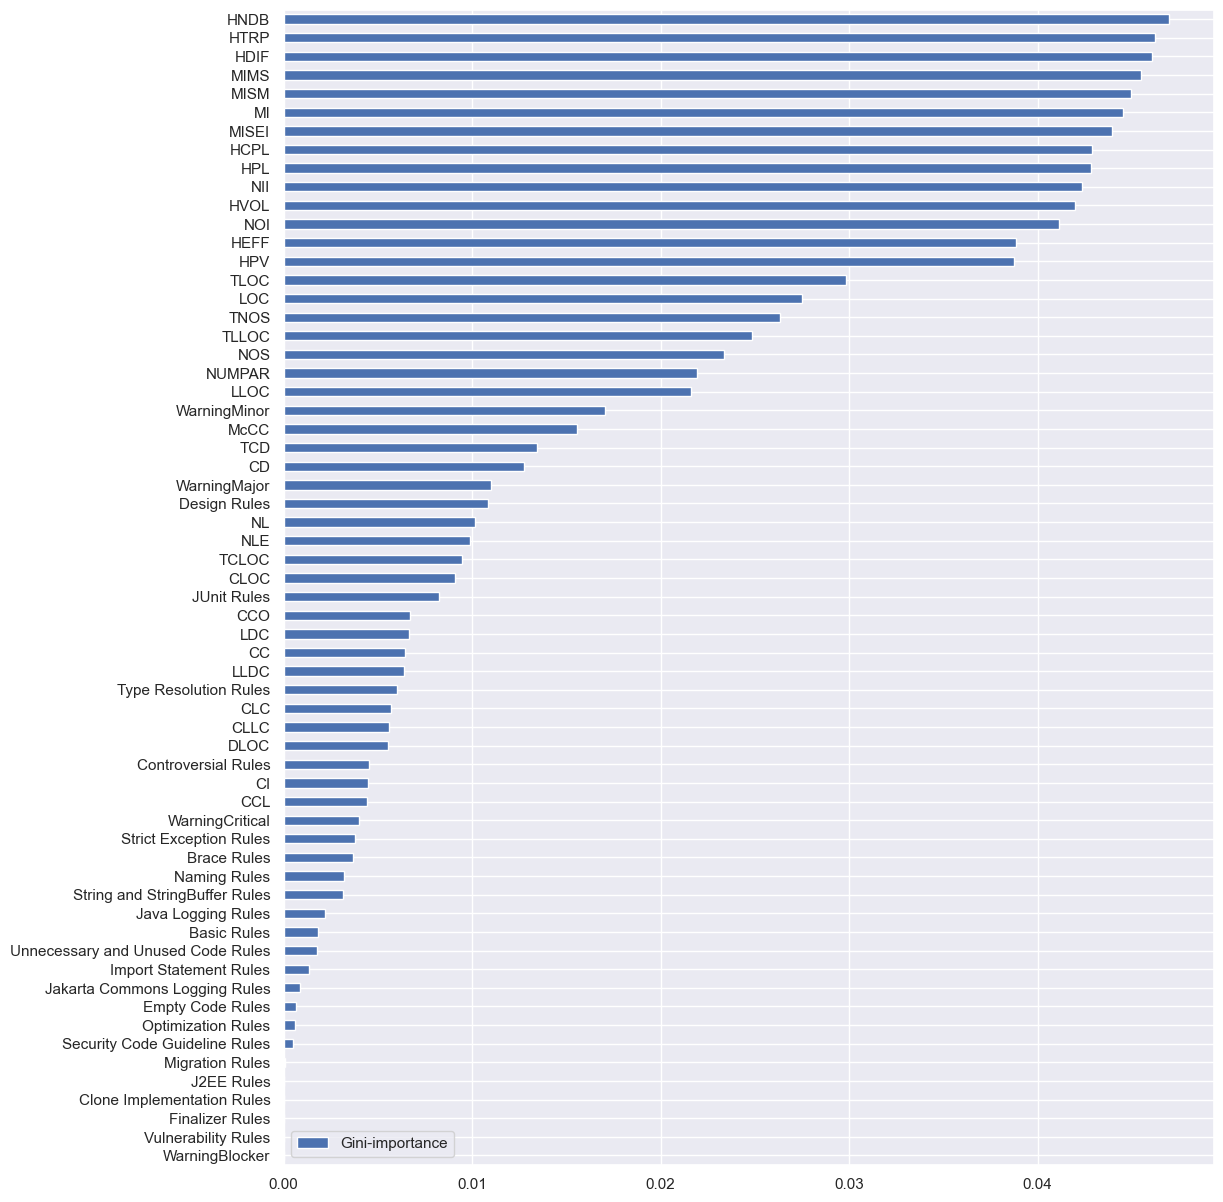

In [23]:
feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(x.columns, rf.feature_importances_):
    feats[feature] = importance #add the name/value pair 

importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-importance'})
importances.sort_values(by='Gini-importance').plot(kind='barh', figsize = (12,15))

In [24]:
# Get numerical feature importances
importances = list(rf.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, importance) for feature, importance in zip(x.columns, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
# [print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances]

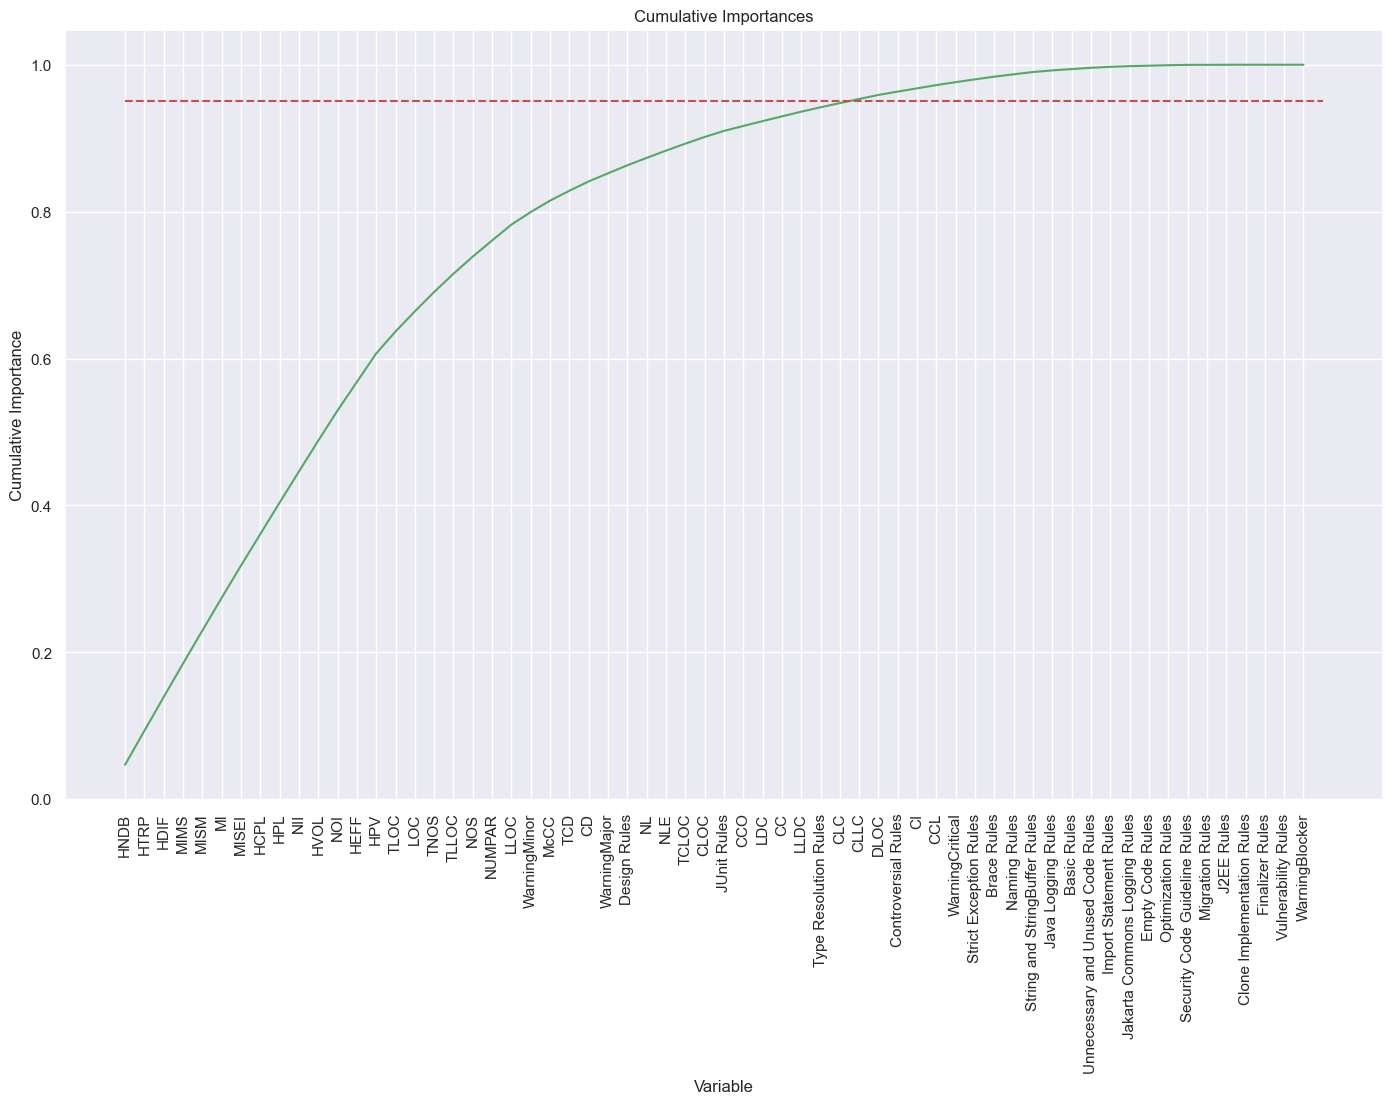

In [25]:
x_values = list(range(len(importances)))
# Lista de features ordenadas por importancia
sorted_importances = [importance[1] for importance in feature_importances]
sorted_features = [importance[0] for importance in feature_importances]
# Importancia acumulada
cumulative_importances = np.cumsum(sorted_importances)
# Line graph
plt.figure(figsize = (17,10))
plt.plot(x_values, cumulative_importances, 'g-')
# Draw line at 95% of importance retained
plt.hlines(y = 0.95, xmin=0, xmax=len(sorted_importances), color = 'r', linestyles = 'dashed')
# Format x ticks and labels
plt.xticks(x_values, sorted_features, rotation = 'vertical')
# Axis labels and title
plt.xlabel('Variable'); plt.ylabel('Cumulative Importance'); plt.title('Cumulative Importances');

## Modelo reducido

In [26]:
# Find number of features for cumulative importance of 95%
# Add 1 because Python is zero-indexed
n_important = np.where(cumulative_importances > 0.95)[0][0] + 1
print('Number of features for 95% importance:', n_important)

# Lista de nombres de las variables mas importantes 
important_feature_names = [feature[0] for feature in feature_importances[0:n_important]]
# Lista de indices de las variables mas importantes 
important_indices = [list(x.columns).index(feature) for feature in important_feature_names]
print(tuple(zip(important_feature_names, important_indices)))

# Create training and testing sets with only the important features
X_train_reduced = X_train.iloc[:, important_indices]
X_test_reduced = X_test.iloc[:, important_indices]
# Sanity check on operations
print('Important train features shape:', X_train_reduced.shape)
print('Important test features shape:', X_test_reduced.shape)

Number of features for 95% importance: 39
(('HNDB', 11), ('HTRP', 14), ('HDIF', 9), ('MIMS', 17), ('MISM', 19), ('MI', 16), ('MISEI', 18), ('HCPL', 8), ('HPL', 12), ('NII', 23), ('HVOL', 15), ('NOI', 24), ('HEFF', 10), ('HPV', 13), ('TLOC', 35), ('LOC', 31), ('TNOS', 36), ('TLLOC', 34), ('NOS', 32), ('NUMPAR', 33), ('LLOC', 30), ('WarningMinor', 40), ('McCC', 20), ('TCD', 28), ('CD', 25), ('WarningMajor', 39), ('Design Rules', 45), ('NL', 21), ('NLE', 22), ('TCLOC', 29), ('CLOC', 26), ('JUnit Rules', 50), ('CCO', 2), ('LDC', 6), ('CC', 0), ('LLDC', 7), ('Type Resolution Rules', 59), ('CLC', 4), ('CLLC', 5))
Important train features shape: (119674, 39)
Important test features shape: (21622, 39)


### Reajuste de hiperparámetros

In [27]:
rf_reduced = RandomForestClassifier(random_state = 42)

search_space = {
    "max_depth": [10, 20, 50],
    "max_features": [5, 10], 
    "min_samples_leaf" : [10, 50, 100],
    "min_samples_split": [10, 50, 100],
    "n_estimators": [50, 100, 200]
}

GS_reduced = GridSearchCV(estimator = rf,
                 param_grid = search_space,
                 scoring = ["r2", "neg_root_mean_squared_error"],
                 refit = "r2",
                 cv = 5,
                 verbose = 4, 
                 n_jobs=-1)

GS_reduced.fit(X_train_reduced, y_train)

print(GS_reduced.best_params_)

# MAX_DEPTH = 100 > 30, 50, 75
# MAX_FEATURES = 5 > 10, 15
# MIN_SAMPLES_LEAF = 1 > 2
# MIN_SAMPLES_SPLIT = 1 > 2, 3
# N_ESTIMATORS = 1000 > 200, 500

'''
Fitting 5 folds for each of 2 candidates, totalling 10 fits
{'max_depth': 40, 'max_features': 35, 'min_samples_leaf': 1, 'min_samples_split': 1, 'n_estimators': 600}
'''

MAX_DEPTH = 100
MAX_FEATURES = 5
MIN_SAMPLES_LEAF = 1
MIN_SAMPLES_SPLIT = 1
N_ESTIMATORS = 1000

              precision    recall  f1-score   support

           0       0.78      0.88      0.83     14945
           1       0.62      0.44      0.52      6677

    accuracy                           0.75     21622
   macro avg       0.70      0.66      0.67     21622
weighted avg       0.73      0.75      0.73     21622



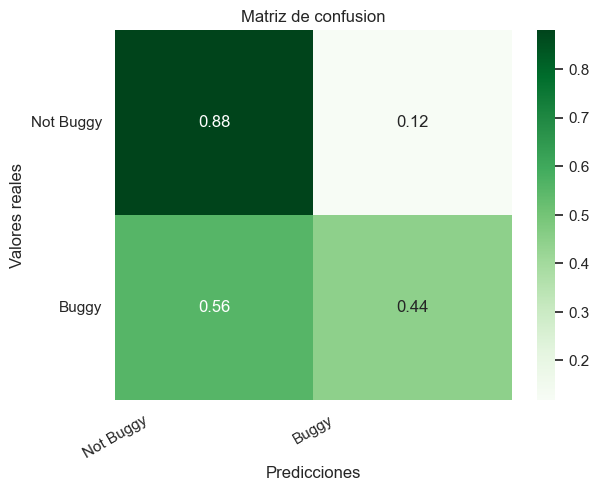

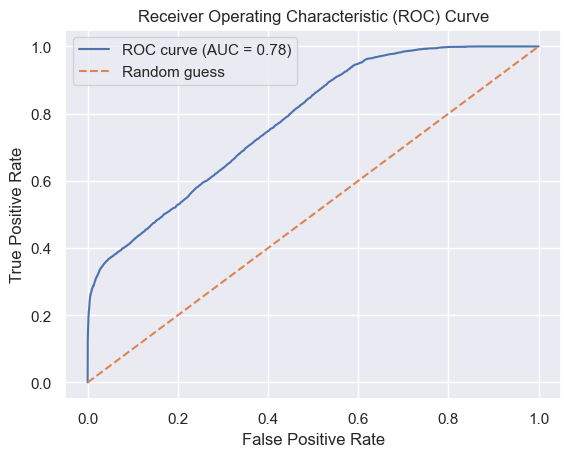

In [154]:
# Modelo reducido
rf_reduced = RandomForestClassifier(max_depth = 15, max_features = 5, min_samples_leaf = 3, min_samples_split = 15, n_estimators = 50, n_jobs = -1)
# rf_reduced = RandomForestClassifier(max_depth = 20, max_features = 10, min_samples_leaf = 3, min_samples_split = 75, n_estimators = 100, n_jobs = -1)
# rf_reduced = RandomForestClassifier(max_depth = 20, max_features = 5, min_samples_leaf = 1, min_samples_split = 75, n_estimators = 100, n_jobs = -1)
# rf_reduced = RandomForestClassifier(max_depth = 100, max_features = 5, min_samples_leaf = 1, min_samples_split = 75, n_estimators = 200, n_jobs = -1)
# rf_reduced = RandomForestClassifier(max_depth = 100, max_features = 5, min_samples_leaf = 1, min_samples_split = 1, n_estimators = 1000, n_jobs = -1)

# Entrenamiento del modelo
rf_reduced.fit(X_train_reduced, y_train)
y_pred = rf_reduced.predict(X_test_reduced)
evaluacion_modelo(rf_reduced, X_test_reduced, y_test, y_pred)

### Evaluación rápida del modelo

              precision    recall  f1-score   support

           0       0.80      0.74      0.77     14945
           1       0.50      0.58      0.54      6677

    accuracy                           0.69     21622
   macro avg       0.65      0.66      0.65     21622
weighted avg       0.71      0.69      0.70     21622



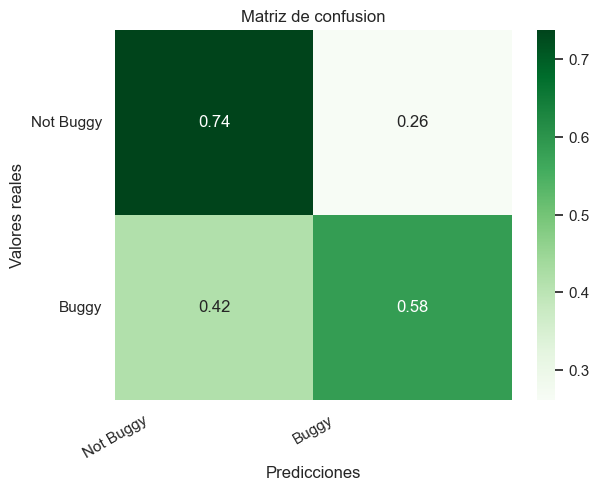

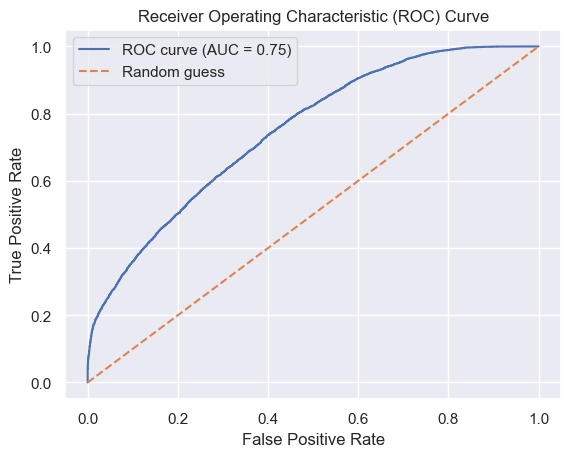

In [123]:
y_pred = rf_reduced.predict(X_test_reduced)
evaluacion_modelo(rf_reduced, X_test_reduced, y_test, y_pred)

In [73]:
entry_to_explain = ENTRIES_TO_EXPLAIN[2]

# Shap

In [30]:
shap_explainer = shap.TreeExplainer(rf_reduced)
shap.initjs()

## Resumen Global

In [31]:
# Plot de resumen global 
entry_to_explain = ENTRIES_TO_EXPLAIN[0]
# Ejemplo rápido
# shap.summary_plot(shap_explainer.shap_values(X_test.iloc[entry_to_explain-1:entry_to_explain,:]), X_test, plot_type="bar")

# Resumen completo
# shap.summary_plot(shap_explainer.shap_values(X_test), X_test, plot_type="bar")

## Explicación local

In [41]:
# Plots para SHAP 

print(f'PROBABILIDADES:\n\tNO BUGGY: {rf_reduced.predict_proba(X_test_reduced)[entry_to_explain, 0]}\n\tBUGGY: {rf_reduced.predict_proba(X_test_reduced)[entry_to_explain, 1]}')

shap_values = shap_explainer.shap_values(np.array(X_test_reduced.iloc[entry_to_explain]))
shap.force_plot(shap_explainer.expected_value[1], shap_values[1], X_test_reduced.iloc[entry_to_explain])

PROBABILIDADES:
	NO BUGGY: 0.578
	BUGGY: 0.422


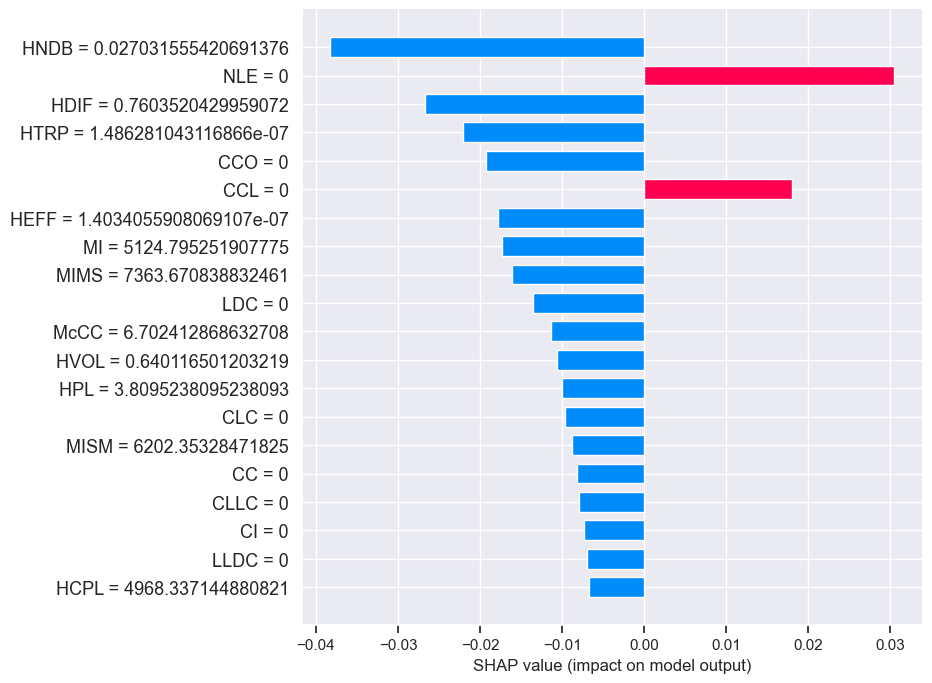

In [34]:
plt.figure(figsize=(8,8))
shap.bar_plot(shap_values[1], features=X_test.iloc[entry_to_explain], max_display=20)

In [93]:
shap.initjs()
explainer_rfc = shap.Explainer(rf_reduced)
shap_values_rfc = explainer_rfc(X_test_reduced[entry_to_explain:entry_to_explain+1])

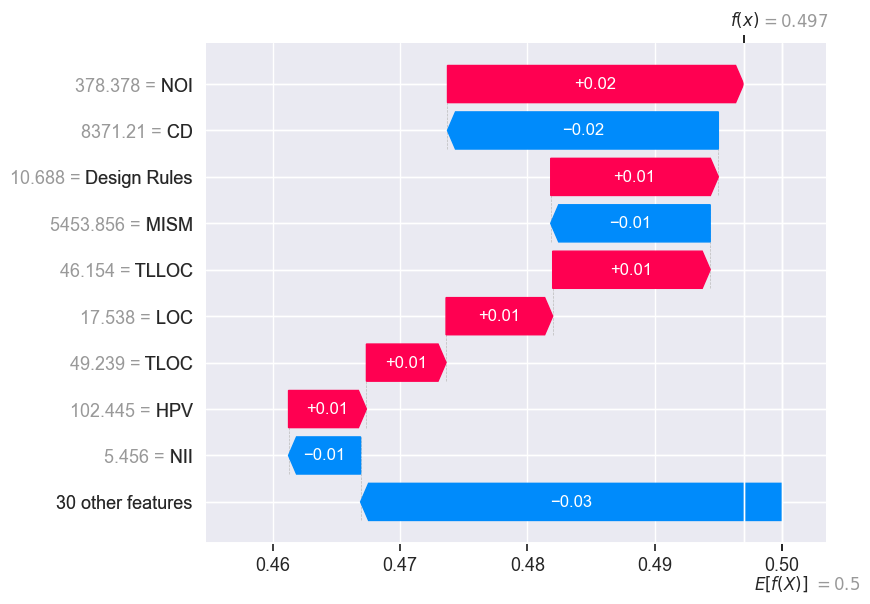

In [94]:
shap.plots.waterfall(shap_values_rfc[0,:,1])

In [95]:
print(f'PROBABILIDADES:\n\tNO BUGGY: {rf_reduced.predict_proba(X_test_reduced)[entry_to_explain, 0]}\n\tBUGGY: {rf_reduced.predict_proba(X_test_reduced)[entry_to_explain, 1]}')

shap.plots.force(shap_values_rfc[0, :, 1])

PROBABILIDADES:
	NO BUGGY: 0.503
	BUGGY: 0.497


## Funciones shap

In [34]:
def shap_force_plot(data:pd.DataFrame, exp:shap.TreeExplainer, x:int): 
    for i in range(x): 
        sv = exp.shap_values(np.array(data.iloc[i]))
        shap.force_plot(exp.expected_value[1], sv[1], data.iloc[i], matplotlib=True, show=False)
        plt.savefig(f"./img/shap/{i}_force.png", dpi=200, bbox_inches='tight')
        plt.clf()

def shap_bar_plot(data:pd.DataFrame, exp:shap.TreeExplainer, x:int): 
    plt.figure(figsize=(8,8))
    for i in range(x): 
        sv = exp.shap_values(np.array(data.iloc[i]))
        shap.bar_plot(sv[1], features=data.iloc[i], max_display=10, show=False)
        plt.savefig(f"./img/shap/{i}_bar.png", bbox_inches='tight')
        plt.clf()

# shap_force_plot(data=X_test_reduced, exp=shap_explainer, x=100)
# shap_bar_plot(data=X_test_reduced, exp=shap_explainer, x=100)

# Lime

In [49]:
lime_explainer = lime.lime_tabular.LimeTabularExplainer(X_train_reduced.values, feature_names=X_train_reduced.columns, class_names=['Not Buggy', 'Buggy'], verbose=True, mode='classification')

In [92]:
# Cada vez que se ejecuta el explicador, lime genera datos cercanos perturbando las features de la instancia, esto puede hacer que en cada iteración el resultado del peso de las variabes sobre la predicción varíe. Ver https://lime-ml.readthedocs.io/en/latest/lime.html#lime.lime_tabular.LimeTabularExplainer.explain_instance
exp = lime_explainer.explain_instance(X_test_reduced.values[entry_to_explain], rf_reduced.predict_proba, num_features=5, top_labels=1)
exp.show_in_notebook(show_table=True, show_all=False)

c:\Users\david\Desktop\bug-prediction-explanation\env\lib\site-packages\sklearn\base.py:420: UserWarning:

X does not have valid feature names, but RandomForestClassifier was fitted with feature names



Intercept 0.6319996305979336
Prediction_local [0.61778668]
Right: 0.503


## Funciones Lime

In [36]:
def lime_explain(data:pd.DataFrame, explainer:lime.lime_tabular.LimeTabularExplainer, model:RandomForestClassifier , x:int): 
    for i in range(x): 
        exp = explainer.explain_instance(data.iloc[i], model.predict_proba, num_features=10, top_labels=1)
        exp.save_to_file(f"./img/lime/{i}.html")

lime_explain(data=X_test_reduced, explainer=lime_explainer, model=rf_reduced, x=100)

X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassif

# Comparaciones totales
https://github.com/interpretml/interpret/tree/develop

https://github.com/interpretml/interpret/blob/develop/examples/python/Explaining_Blackbox_Classifiers.ipynb

In [38]:
background_val = pd.DataFrame(np.median(X_train_reduced, axis=0).reshape(1, -1), columns=X_train_reduced.columns)
sp = ShapKernel(rf_reduced, background_val)
shap_local = sp.explain_local(X_test_reduced[:5], y_test[:5], name='SHAP')

#Blackbox explainers need a predict function, and optionally a dataset
lim = LimeTabular(rf_reduced, X_train_reduced, random_state=1)

#Pick the instances to explain, optionally pass in labels if you have them
lime_local = lim.explain_local(X_test_reduced[:100], y_test[:100], name='LIME')

show([lime_local, shap_local])

100%|██████████| 5/5 [00:01<00:00,  4.00it/s]


<!-- http://127.0.0.1:7001/3222090640064/ -->
 Open in new window

# Tree schemas
https://towardsdatascience.com/random-forest-in-python-24d0893d51c0

In [37]:
# Ejectura esta parte si está instalado graphviz en el equipo
# from sklearn.tree import export_graphviz
# import graphviz
# for i in [5, 23, 30, 47, 70, 95]:
#     tree = rf.estimators_[i]
#     dot_data = export_graphviz(tree,
#                                feature_names=X_train.columns,  
#                                filled=True,  
#                                max_depth=4, 
#                                impurity=False, 
#                                proportion=True)
#     graph = graphviz.Source(dot_data)
#     graph.render(filename=f'g1.dot')
#     display(graph)

# XGBoost

In [97]:
from xgboost import XGBRegressor
xgb_model = XGBRegressor(random_state = 42)

search_space = {
    "n_estimators": [500, 1000],
    "max_depth": [35, 50],
    'gamma': [0.5, 1],
    'learning_rate': [0.1, 0.01]
}

GS = GridSearchCV(estimator = xgb_model,
                 param_grid = search_space,
                 scoring = ["r2", "neg_root_mean_squared_error"],
                 refit = "r2",
                 cv = 5,
                 verbose = 4, 
                 n_jobs=-1)

# GS.fit(X_train_reduced, y_train)

# print(GS.best_params_)

# {'gamma': 0.5, 'learning_rate': 0.01, 'max_depth': 50, 'n_estimators': 700}

GAMMA_XGB = 0.5
LEARNING_RATE_XGB = 0.01
MAX_DEPTH_XGB = 50
N_ESTIMATORS_XGB = 700

# xgb_model = xgb.XGBClassifier(gamma = 0.01, learning_rate = 0.01, max_depth = 5, n_estimators = 50, n_jobs = -1) 

In [118]:
# Definición del modelo XGBoost
xgb_model = xgb.XGBClassifier(gamma = 0.01, learning_rate = 0.01, max_depth = 1000, n_estimators = 1000, n_jobs = -1)

# Entrenamos el modelo
xgb_model.fit(X_train_reduced, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.01, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=1000, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=1000, n_jobs=-1, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

              precision    recall  f1-score   support

           0       0.78      0.86      0.82     14945
           1       0.60      0.46      0.52      6677

    accuracy                           0.74     21622
   macro avg       0.69      0.66      0.67     21622
weighted avg       0.73      0.74      0.73     21622



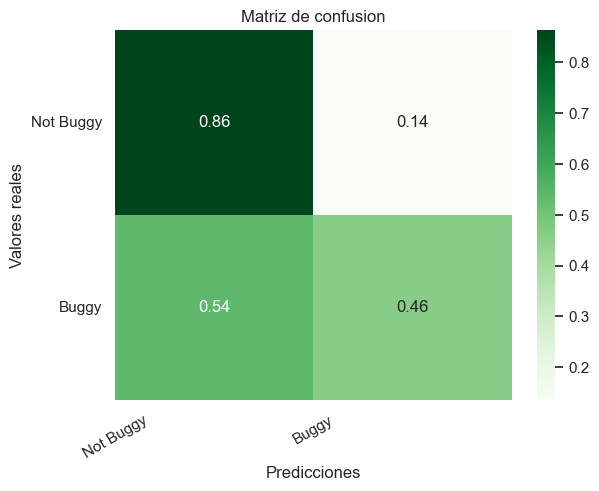

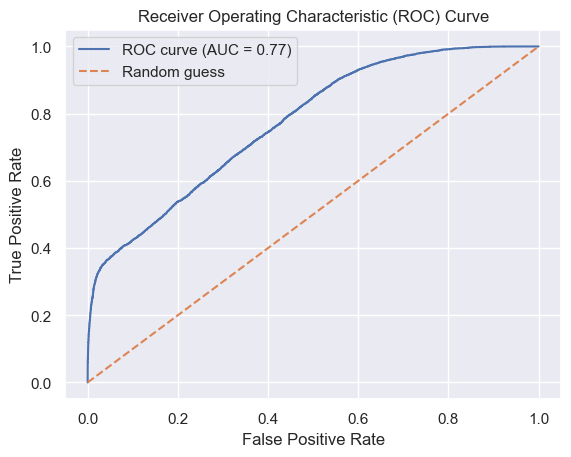

In [119]:
# Comprobamos la precisión en las predicciones del modelo
y_pred = xgb_model.predict(X_test_reduced)
evaluacion_modelo(xgb_model, X_test_reduced, y_test, y_pred)